Make rivers constant or rivers monthly or rivers daily files.  
Conservative emperature now set in these files.  
They have flux, area, depth and conservative temperature

In [1]:
import datetime as dt
import gsw
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from salishsea_tools import rivertools, nc_tools, viz_tools
from salishsea_tools import river_201702 as rivers

prop_dict_name ='river_201702'

%matplotlib inline

In [2]:
import importlib
importlib.reload(rivers)
importlib.reload(rivertools)

<module 'salishsea_tools.rivertools' from '/ocean/sallen/allen/research/Meopar/tools/SalishSeaTools/salishsea_tools/rivertools.py'>

In [3]:
#what type of file would you like to create?
#e.g. 'constant' - yearly average used for all months
#     'monthly' - monthly averages used for each month ** CHANGE BOTH THESE LINES **
#     'daily' - smoothed to daily from monthly averages
rivertype = 'daily'

# what file name do you want to produce?
netcdf_file = 'rivers_daily_201702.nc'

numtimes = 366

In [4]:
# what coordinates are you using?
gridcoords = 'coordinates_seagrid_SalishSea201702.nc'
coords_file = '../../../grid/'+gridcoords
# where is the river information? 
prop_dict = rivers.prop_dict

In [5]:
#get dimensions for netcdf files
fB = xr.open_dataset(coords_file, decode_times=False)
lat = fB['nav_lat'][:]
lon = fB['nav_lon'][:]
e1t = fB['e1t'][0,:]
e2t = fB['e2t'][0,:]
horz_area = e1t*e2t
fB.close()

In [6]:
#get watershed fluxes from netcdf file
if rivertype == 'constant':
    fluxfile = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_cnst.nc','r')
    #inialise the runoff and run_depth arrays
    runoff = np.zeros_like(horz_area)
if rivertype == 'monthly':
    fluxfile = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_monthly.nc','r')
    #inialise the runoff and run_depth arrays
    runoff = np.zeros((12, horz_area.shape[0], horz_area.shape[1]))
if rivertype == 'daily':
    fluxfile = xr.open_dataset('../../../rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')
    runoff = np.zeros((366, horz_area.shape[0], horz_area.shape[1]))

In [7]:
#list of watersheds we are including
names = ['skagit', 'fraser', 'evi_n', 'howe', 'bute', 'puget', 'jdf', 'evi_s', 'jervis', 'toba']

In [8]:
run_depth = np.ones_like(runoff)
run_temp = np.empty_like(runoff)
for name in range(0,len(names)):
    watershedname = names[name]
    print (watershedname)
    Flux = fluxfile[watershedname][:]
    if rivertype == 'constant':
        Flux = float(Flux)
    runoff_orig = np.copy(runoff)
    runoff, run_depth, run_temp = rivertools.put_watershed_into_runoff(rivertype, horz_area,
                                            Flux, runoff, run_depth, run_temp,
                                            prop_dict[watershedname])
    if rivertype == 'constant':
        rivertools.check_sum(runoff_orig, runoff, Flux, horz_area)
    elif rivertype == 'monthly':
        rivertools.check_sum_monthly(runoff_orig, runoff, Flux, horz_area)
    elif rivertype == 'daily':
        rivertools.check_sum_monthly(runoff_orig, runoff, Flux, np.array(horz_area), numtimes=365)
        # add a day for leapyears
        runoff[365] = runoff[364]
        run_depth[365] = run_depth[364]
        run_temp[365] = run_temp[364]


skagit
936.9981462047525 <xarray.DataArray 'skagit' ()>
array(936.99811644) <xarray.DataArray 'skagit' ()>
array(1.00000003)
fraser
3547.246776473081 <xarray.DataArray 'fraser' ()>
array(3547.24931507) <xarray.DataArray 'fraser' ()>
array(0.99999928)
evi_n
249.67441797497273 <xarray.DataArray 'evi_n' ()>
array(638.2635274) <xarray.DataArray 'evi_n' ()>
array(0.39117764)
howe
572.3552964981039 <xarray.DataArray 'howe' ()>
array(572.38531678) <xarray.DataArray 'howe' ()>
array(0.99994755)
bute
549.8597184810711 <xarray.DataArray 'bute' ()>
array(549.99482021) <xarray.DataArray 'bute' ()>
array(0.99975436)
puget
502.5881711079663 <xarray.DataArray 'puget' ()>
array(502.58818493) <xarray.DataArray 'puget' ()>
array(0.99999997)
jdf
409.7373864017057 <xarray.DataArray 'jdf' ()>
array(409.73737158) <xarray.DataArray 'jdf' ()>
array(1.00000004)
evi_s
329.5534830494848 <xarray.DataArray 'evi_s' ()>
array(329.55798373) <xarray.DataArray 'evi_s' ()>
array(0.99998634)
jervis
296.6680071161192 <xar

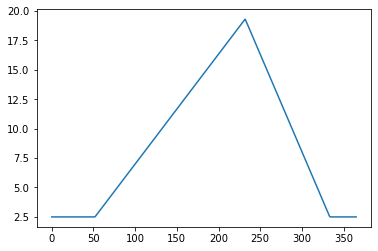

In [21]:
plt.plot(run_temp[:, 878, 58]);

**Temperature is in-situ/potential, make it conservative**

In [9]:
sal_ref = np.zeros_like(run_temp)

In [10]:
temp_cons = gsw.CT_from_pt(sal_ref, run_temp)

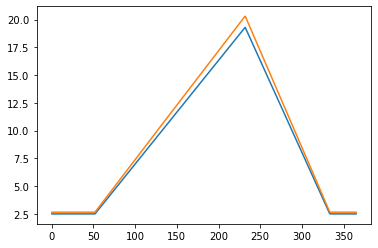

In [11]:
plt.plot(run_temp[:, 878, 58]);
plt.plot(temp_cons[:, 878, 58]);

(300.0, 398.0)

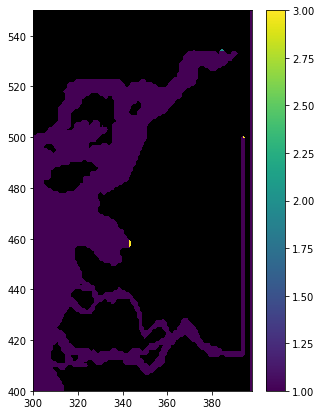

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 7))
#plt.plot(run_depth[:, 878, 58]);
colours = ax.pcolormesh(run_depth[15])
fig.colorbar(colours)
viz_tools.plot_land_mask(ax, '/home/sallen/MEOPAR/grid/bathymetry_201702.nc');
viz_tools.set_aspect(ax)
#plt.plot(run_depth[:, 550, 396])
ax.set_ylim(400, 550)
ax.set_xlim(300, 398)

In [13]:
# set up titles
netcdf_title = rivertype+' rivers for '+prop_dict_name
netcdf_comment = netcdf_title+' on '+ gridcoords
notebook = 'MakeClimatologyRiverFilesWithArea.ipynb'

ds_attrs = {
    'acknowledgements':
            'Based on Morrison et al climatology and Allen and Wolfe temperature',
        'creator_email':
            'sallen@eoas.ubc.ca',
        'creator_name':
            'Salish Sea MEOPAR Project Contributors',
        'creator_url':
            'https://salishsea-meopar-docs.readthedocs.org/',
        'institution':
            'UBC EOAS',
        'institution_fullname': (
            'Earth, Ocean & Atmospheric Sciences,'
            ' University of British Columbia'
        ),
    'title': netcdf_title,
    'comment': netcdf_comment,
    'notebook': notebook,
    'summary': f'Runoff, area, depth and conservative temperature of runoff {rivertype}',
    'history': (
            '[{}] File creation.'
            .format(dt.datetime.today().strftime('%Y-%m-%d'))
        )
}

coords_c = {
    'x' : np.arange(horz_area.shape[1]),
    'y' : np.arange(horz_area.shape[0]),
}

coords = {
    'x' : np.arange(horz_area.shape[1]),
    'y' : np.arange(horz_area.shape[0]),
    'time_counter' : np.arange(numtimes)
}

data_c = {}
var_attrs_c = {} 
data_c['nav_lat'] = lat
var_attrs_c['nav_lat'] = {'units': 'degrees_north',
                       'long_name': 'latitude'}
data_c['nav_lon'] = lon
var_attrs_c['nav_lon'] = {'units': 'degrees_east',
                       'long_name': 'latitude'}
data_c['area'] = horz_area
var_attrs_c['area'] = {'units': 'm2',
                     'long_name': 'horizontal_grid_cell_area'}

da = {}
for var in data_c:
    da[var] = xr.DataArray(
        data = data_c[var],
        name=var,
        dims=('y', 'x'),
        coords = coords_c,
        attrs = var_attrs_c[var])

data = {}
var_attrs = {}

var_attrs['rorunoff'] = {'units': 'kg m-2 s-1',
                      'long_name': 'runoff_flux'}
data['rorunoff'] = runoff
var_attrs['rodepth'] = {'units': 'm',
                      'long_name': 'maximum_runoff_depth'}
data['rodepth'] = run_depth

var_attrs['rotemper'] = {'units': 'oC',
                      'long_name': 'river water conservative temperature'}
data['rotemper'] = temp_cons

for var in data:
    da[var] = xr.DataArray(
        data = data[var],
        name=var,
        dims=('time_counter', 'y', 'x'),
        coords = coords,
        attrs = var_attrs[var])
    

ds = xr.Dataset(
        data_vars={
            'nav_lat': da['nav_lat'],
            'nav_lon': da['nav_lon'],
            'area': da['area'],
            'rorunoff': da['rorunoff'],
            'rodepth': da['rodepth'],
            'rotemper': da['rotemper']},
        coords = coords,
        attrs = ds_attrs
)

ds

<xarray.Dataset>
Dimensions:       (time_counter: 366, x: 398, y: 898)
Coordinates:
  * x             (x) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
  * y             (y) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * time_counter  (time_counter) int64 0 1 2 3 4 5 6 ... 360 361 362 363 364 365
Data variables:
    nav_lat       (y, x) float32 46.86 46.86 46.86 46.87 ... 51.1 51.1 51.1 51.1
    nav_lon       (y, x) float32 -123.4 -123.4 -123.4 ... -124.4 -124.3 -124.3
    area          (y, x) float64 1.852e+05 1.908e+05 ... 1.764e+05 1.755e+05
    rorunoff      (time_counter, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rodepth       (time_counter, y, x) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    rotemper      (time_counter, y, x) float64 0.01528 0.01528 ... 0.01528
Attributes:
    acknowledgements:      Based on Morrison et al climatology and Allen and ...
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    title:                 daily rivers for river_201702
    comment:               daily rivers for river_201702 on coordinates_seagr...
    notebook:              MakeClimatologyRiverFilesWithArea.ipynb
    summary:               Runoff, area, depth and conservative temperature o...
    history:               [2020-12-23] File creation.

In [14]:
encoding = {var: {'zlib': True} for var in ds.data_vars}

ds.to_netcdf(netcdf_file, unlimited_dims=('time_counter'),
        encoding=encoding,)

**Your file has now been created.  Move it into rivers-climatology and commit**